In [1]:
#import library yang dibutuhkan
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from PIL import Image
from numpy import asarray

from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras import datasets, layers, models

In [2]:
#mendownload dataset cat and dog di link tersebut dan disimpan dalam cats_and_dogs.zip
#dataset diekstrak
_URL = 'http://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

#hasil ekstrak disimpan di folder bernama cats_and_dog_filtered
#terdiri dari train: 1000 cats + 1000 dogs dan validation: 500 cats + 100 cats
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160,160)

#ekstrak dan menyusun dataset untuk train dan validation
#mengambil semua gambar untuk train menjadi train dataset dan validation menjadi train validation
#0 cats 1 dogs
#batch_size berfungsi untuk mengumpulkan gambar-gambar yang banyak dalam suatu kuantitas yang ditetapkan untuk dapat melakukan proses komputasi yang lebih baik
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


1

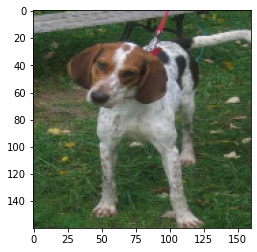

In [3]:
#melakukan pengecekan dan pembuktian dataset (opsional)
for images, labels in train_dataset.take(1): #mengambil elemen/gambar pertama dari train
    images = images.numpy()
    labels = labels.numpy()

plt.imshow(images[0].astype("uint8"))
labels[0]

In [7]:
#mencoba dengan menggunakan model sendiri
model = tf.keras.models.Sequential([
    #convolution layer 1 dengan 1x1
    tf.keras.layers.Conv2D(filters = 1, kernel_size = 3, padding = 'same', activation = 'relu', input_shape=(160, 160, 3)),
    #convolution layer 2 3x3
    tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, padding = 'same', activation = 'relu'),
    #convolution layer 3 5x5
    tf.keras.layers.Conv2D(filters = 5, kernel_size = 3, padding = 'same', activation = 'relu'),
    #convolution layer 4 3x3
    tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, padding = 'same', activation = 'relu'),
    #maxpooling 1
    tf.keras.layers.MaxPooling2D(2,2),
    #flatten layer konversi indeks array ke single vektor
    tf.keras.layers.Flatten(),
    #fullyconnected layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    #model output
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
#optimasi self model
optimize = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='binary_crossentropy', optimizer=optimize, metrics=['accuracy'])

#train self model
model_fit = model.fit(train_dataset,
                      epochs = 10,
                      validation_data = validation_dataset)

Epoch 1/10
63/63 [==============================] - 85s 1s/step - loss: 42.1681 - accuracy: 0.5155 - val_loss: 4.3405 - val_accuracy: 0.5550
Epoch 2/10
63/63 [==============================] - 84s 1s/step - loss: 1.7458 - accuracy: 0.6345 - val_loss: 1.1490 - val_accuracy: 0.6160
Epoch 3/10
63/63 [==============================] - 84s 1s/step - loss: 0.7737 - accuracy: 0.7125 - val_loss: 1.2193 - val_accuracy: 0.5900
Epoch 4/10
63/63 [==============================] - 83s 1s/step - loss: 0.4655 - accuracy: 0.7955 - val_loss: 1.4928 - val_accuracy: 0.5790
Epoch 5/10
63/63 [==============================] - 84s 1s/step - loss: 0.3169 - accuracy: 0.8590 - val_loss: 1.4759 - val_accuracy: 0.6060
Epoch 6/10
63/63 [==============================] - 84s 1s/step - loss: 0.2232 - accuracy: 0.9095 - val_loss: 1.0836 - val_accuracy: 0.6140
Epoch 7/10
63/63 [==============================] - 84s 1s/step - loss: 0.1123 - accuracy: 0.9690 - val_loss: 1.1048 - val_accuracy: 0.6000
Epoch 8/10
63/63 [=

In [4]:
#menggunakan MobileNetV2
#ukuran input (160,160,3)
#include top false --> untuk menghilangkan bagian setelah fungsi flatten
IMG_SHAPE = IMG_SIZE + (3,)
MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
#membuat arsitektur MobileNetV2 tidak melakukan train ulang (mempertahankan kecerdasannya)
MobileNetV2.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


In [5]:
#mendefinisikan modifikasi MobileNetV2 sebagai model_baru
inputs = tf.keras.Input(shape=(160, 160, 3))
#input masuk ke rescalling
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)
#hasil rescale masuk ke mobilenetv2
x = MobileNetV2(x, training = False)
#hasil mobilenetv2 ke average pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#masukkan hasil pooling ke 1 node
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
#layer global average pooling dan 1 node masih random
model_baru = tf.keras.Model(inputs, outputs)

In [9]:
#mengcompile model
model_baru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                   metrics=['accuracy'])

In [11]:
#melakukan pelatihan model untuk dua layer terakhir
history=model_baru.fit(train_dataset,
                       epochs=10,
                       validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 63s 930ms/step - loss: 0.2388 - accuracy: 0.9135 - val_loss: 0.0963 - val_accuracy: 0.9760
Epoch 2/10
63/63 [==============================] - 59s 935ms/step - loss: 0.0790 - accuracy: 0.9765 - val_loss: 0.0683 - val_accuracy: 0.9820
Epoch 3/10
63/63 [==============================] - 57s 908ms/step - loss: 0.0574 - accuracy: 0.9850 - val_loss: 0.0578 - val_accuracy: 0.9820
Epoch 4/10
63/63 [==============================] - 58s 925ms/step - loss: 0.0456 - accuracy: 0.9895 - val_loss: 0.0513 - val_accuracy: 0.9850
Epoch 5/10
63/63 [==============================] - 60s 951ms/step - loss: 0.0381 - accuracy: 0.9895 - val_loss: 0.0481 - val_accuracy: 0.9830
Epoch 6/10
63/63 [==============================] - 59s 931ms/step - loss: 0.0328 - accuracy: 0.9925 - val_loss: 0.0449 - val_accuracy: 0.9850
Epoch 7/10
63/63 [==============================] - 59s 930ms/step - loss: 0.0290 - accuracy: 0.9955 - val_loss: 0.0432 - val_accuracy: 0.9840

In [12]:
#melakukan train pada beberapa layer di MobileNetV2
#melakukan train pada layer ditujukan untuk pengaplikasian model dengan perbedaan dataset yang cukup ekstrim dengan model

#membuat model trainable
MobileNetV2.trainable=True

#menentukan layer 1-100 tidak di train dan layer 101-154 ditrain ulang
for layer in MobileNetV2.layers[:100]:
  layer.trainable=False

In [17]:
#Mengcompile model hasil modifikasi
model_baru.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [19]:
#train model hasil modifikasi
fine_tune_epochs = 5
initial_epochs = 10

total_epochs = initial_epochs + fine_tune_epochs

history_fine = model_baru.fit(train_dataset,
                              epochs=total_epochs,
                              validation_data=validation_dataset)

Epoch 1/15
63/63 [==============================] - 89s 1s/step - loss: 0.6935 - accuracy: 0.4850 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/15
63/63 [==============================] - 87s 1s/step - loss: 0.6934 - accuracy: 0.4830 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/15
63/63 [==============================] - 90s 1s/step - loss: 0.6934 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/15
63/63 [==============================] - 86s 1s/step - loss: 0.6934 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/15
63/63 [==============================] - 86s 1s/step - loss: 0.6934 - accuracy: 0.4840 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/15
63/63 [==============================] - 85s 1s/step - loss: 0.6934 - accuracy: 0.4940 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/15
63/63 [==============================] - 85s 1s/step - loss: 0.6934 - accuracy: 0.4730 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/15
63/63 [==